<a href="https://colab.research.google.com/github/Shahid1993/colab-notebooks/blob/master/05_THS_Predictive_Keyboard_Using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Making a Predictive Keyboard using Recurrent Neural Networks](https://medium.com/@curiousily/making-a-predictive-keyboard-using-recurrent-neural-networks-tensorflow-for-hackers-part-v-3f238d824218)

# Recurrent Neural Networks

In short, `RNN` models provide a way to not only examine the current input but the one that was provided one step back, as well. If we turn that around, we can say that the decision reached at time step t-1 directly affects the future at step t.

![](https://miro.medium.com/max/947/1*K6s4Li0fTl1pSX4-WPBMMA.jpeg)

## Definition
RNNs define a recurrence relation over time steps which is given by:

![](https://miro.medium.com/max/555/1*3giig0Hb58gDrl1dBdAWSw.png)

Where St is the state at time step t, Xt an exogenous input at time t, Wrec and Wx are weights parameters. The feedback loops gives memory to the model because it can remember information between time steps.

`RNNs` can compute the current state St from the current input Xt and previous state St−1 or predict the next state from St+1 from the current St and current input Xt. Concretely, we will pass a sequence of 40 characters and ask the model to predict the next one. We will append the new character and drop the first one and predict again. This will continue until we complete a whole word.

# LSTMs
Two major problems torment the `RNNs` — **vanishing** and **exploding gradients**. In traditional `RNNs` the gradient signal can be multiplied a large number of times by the weight matrix. Thus, the magnitude of the weights of the transition matrix can play an important role.

If the weights in the matrix are small, the gradient signal becomes smaller at every training step, thus making learning very slow or completely stops it. This is called vanishing gradient. Let’s have a look at applying the sigmoid function multiple times, thus simulating the effect of vanishing gradient:

![](https://miro.medium.com/max/552/1*XbVjM9cPb-BkLrWGNujEQg.png)

Conversely, the exploding gradient refers to the weights in this matrix being so large that it can cause learning to diverge.


`LSTM` model is a special kind of `RNN` that learns long-term dependencies. It introduces new structure — the memory cell that is composed of four elements: input, forget and output gates and a neuron that connects to itself:

![](https://miro.medium.com/max/606/1*ZskkUQCNT0i_00shHYSj1A.png)

`LSTMs` *fight the gradient vanishing problem by preserving the error that can be backpropagated through time and layers*. By maintaining a more constant error, they allow for learning long-term dependencies. On another hand, *exploding is controlled with **gradient clipping***, that is the gradient is not allowed to go above some predefined value.


# Setup
Let’s properly seed our random number generator and import all required modules:

In [1]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns
from pylab import rcParams

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 5

Using TensorFlow backend.


# Loading the data

In [2]:
path = 'nietzsche.txt'
text = open(path).read().lower()
print('corpus length:', len(text))

corpus length: 600902


# Preprocessing

Let’s find all unique chars in the corpus and create char to index and index to char maps:

In [3]:
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print(f'unique chars: {len(chars)}')

unique chars: 59


Next, let’s cut the corpus into chunks of `40` characters, spacing the sequences by `3` characters. Additionally, we will store the next character (the one we need to predict) for every sequence: 

In [4]:
SEQUENCE_LENGTH = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])
print(f'num training examples: {len(sentences)}')

num training examples: 200288


It is time for generating our features and labels. We will use the previously generated sequences and characters that need to be predicted to create one-hot encoded vectors using the `char_indices` map:

In [0]:
X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Let’s have a look at a single training sequence:

In [15]:
sentences[10091]

's!\nsensualism, therefore, at least as re'

The character that needs to be predicted for it is:

In [16]:
next_chars[10091]

'g'

The encoded (one-hot) data looks like this:

In [17]:
X[0][0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [18]:
y[0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

And for the dimensions:

In [19]:
X.shape

(200288, 40, 59)

In [20]:
y.shape

(200288, 59)

We have `200285` training examples, each sequence has length of `40` with `57` unique chars.

# Building the model

The model we’re going to train is pretty straight forward. Single `LSTM` layer with `128` neurons which accepts input of shape (`40` — the length of a sequence, `57` — the number of unique characters in our dataset). A fully connected layer (for our output) is added after that. It has `57` neurons and softmax for activation function:

In [21]:
model = Sequential()
model.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

# Training

Our model is trained for `20` epochs using `RMSProp` optimizer and uses `5%` of the data for validation:

In [22]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 190273 samples, validate on 10015 samples
Epoch 1/20
190273/190273 [==============================] - 132s 693us/step - loss: 2.0099 - acc: 0.4142 - val_loss: 1.6949 - val_acc: 0.4992
Epoch 2/20
190273/190273 [==============================] - 127s 669us/step - loss: 1.6493 - acc: 0.5113 - val_loss: 1.5765 - val_acc: 0.5283
Epoch 3/20
190273/190273 [==============================] - 127s 666us/step - loss: 1.5557 - acc: 0.5364 - val_loss: 1.5251 - val_acc: 0.5419
Epoch 4/20
190273/190273 [==============================] - 127s 665us/step - loss: 1.5076 - acc: 0.5488 - val_loss: 1.5193 - val_acc: 0.5463
Epoch 5/20
190273/190273 [==============================] - 127s 669us/step - loss: 1.4763 - acc: 0.5575 - val_loss: 1.4978 - val_acc: 0.5540
Epoch 6/20
190273/190273 [==============================] - 127s 666us/step - loss: 1.4561 - acc: 0.5623 - val_loss: 1.4846 - val_acc: 0.5543


# Saving

In [0]:
model.save('predictive_keyboard_keras_model.h5')
pickle.dump(history, open("predictive_keyboard_history.p", "wb"))

And load it back, just to make sure it works:

In [0]:
model = load_model('predictive_keyboard_keras_model.h5')
history = pickle.load(open("predictive_keyboard_history.p", "rb"))

# Evaluation

Let’s have a look at how our accuracy and loss change over training epochs:

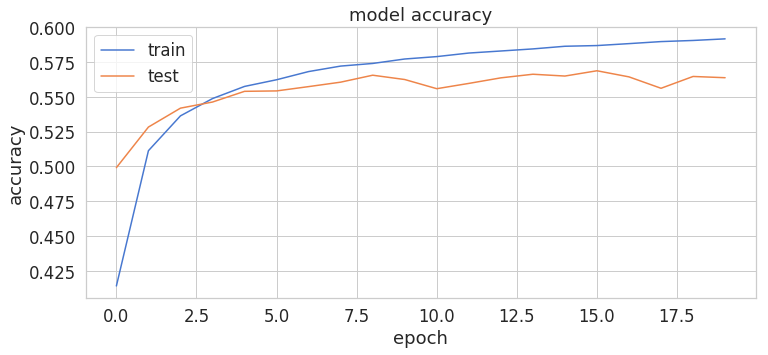

In [26]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

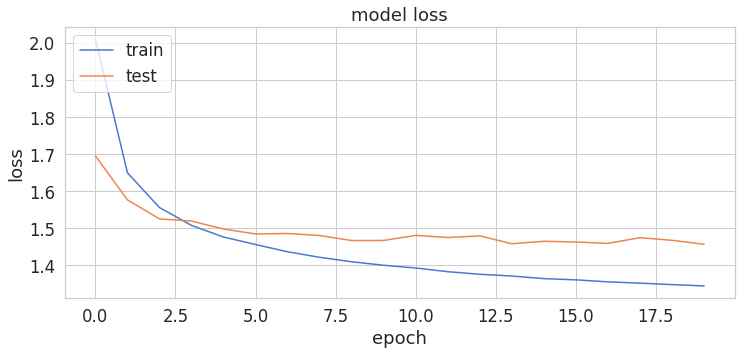

In [27]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

# Let’s put our model to the test

In [0]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

Remember that our sequences must be `40` characters long. So we make a tensor with shape `(1, 40, 59)`, initialized with zeros. Then, a value of 1 is placed for each character in the passed text. We must not forget to use the lowercase version of the text:

In [29]:
prepare_input("This is an example of input for our LSTM".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

#### Next up, the sample function:

This function allows us to ask our model what are the next `n` most probable characters.

In [0]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

Now for the **prediction functions** themselves:

This function predicts next character until space is predicted (you can extend that to punctuation symbols, right?). It does so by repeatedly preparing input, asking our model for predictions and sampling from them.

In [0]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

The final piece of the puzzle — `predict_completions` wraps everything and allow us to predict multiple completions:

In [0]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

Let’s use sequences of 40 characters that we will use as seed for our completions. All of these are quotes from Friedrich Nietzsche himself:

In [0]:
quotes = [
    "It is not a lack of love, but a lack of friendship that makes unhappy marriages.",
    "That which does not kill us makes us stronger.",
    "I'm not upset that you lied to me, I'm upset that from now on I can't believe you.",
    "And those who were seen dancing were thought to be insane by those who could not hear the music.",
    "It is hard enough to remember my opinions, without also remembering my reasons for them!",
    "A man lying on a comfortable sofa is listening to his wi"
]

In [43]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

it is not a lack of love, but a lack of 
['the ', 'a ', 'problem ', 'subject ', 'which ']

that which does not kill us makes us str
['ong ', 'ange ', 'uggle ', 'ength ', 'ictly ']

i'm not upset that you lied to me, i'm u
['nder ', 's ', 'ltimatic ', 't ', 'ible ']

and those who were seen dancing were tho
['u ', 'se ', 'mse ', 'roughly ', ' operate ']

it is hard enough to remember my opinion
[' of ', 's ', ', ', 'al ', 'ing ']

a man lying on a comfortable sofa is lis
['ter ', 'e ', 'k ', 'hes ', 'ple ']



Apart from the fact that the completions look like proper words (remember, we are training our model on characters, not words), they look pretty reasonable as well! Perhaps better model and/or more training will provide even better results?

# Conclusion

We’ve built a model using just a few lines of code in `Keras` that performs reasonably well after just 20 training epochs. Can you try it with your own text? Why not predict whole sentences? Will it work that well in other languages?